<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="#Load-and-prepare-the-data" data-toc-modified-id="Load-and-prepare-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and prepare the data</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualization</a></span></li><li><span><a href="#Fit-the-model" data-toc-modified-id="Fit-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fit the model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#PONER-LA-CONCLUSION-PRINCIPAL" data-toc-modified-id="PONER-LA-CONCLUSION-PRINCIPAL-4.0.0.1"><span class="toc-item-num">4.0.0.1&nbsp;&nbsp;</span>PONER LA CONCLUSION PRINCIPAL</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Load libraries 

In [33]:
import pandas as pd
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import plotly.express as px


import fbprophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

**DOCUMENTATION**

1- Prophet: 

   - https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3
   - https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
   
2- Monte Carlo Chain:

   - https://towardsdatascience.com/mcmc-intuition-for-everyone-5ae79fff22b1

# Load and prepare the data 

In [17]:
df = pd.read_csv("../Data/temp_clean.csv")
df.dtypes
#df.set_index("date", inplace = True)
#df.head()

date              object
Avg_anomalies    float64
dtype: object

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df[["Avg_anomalies"]])

In [19]:
df["Avg_anomalies"] = dataset

In [20]:
df['Datetime'] = pd.to_datetime(df['date'])

In [21]:
#data for model
dff = df.rename(columns={'Datetime': 'ds', 'Avg_anomalies': 'y'})
dff.head()
#data for plot
df_plot = df.set_index('Datetime')
df_plot.drop("date", axis = 1, inplace = True)


In [22]:
dff.tail()

,date,y,ds
1663,2018-08-31,0.711628,2018-08-31
1664,2018-09-30,0.725581,2018-09-30
1665,2018-10-31,0.832558,2018-10-31
1666,2018-11-30,0.734884,2018-11-30
1667,2018-12-31,0.786047,2018-12-31


In [23]:
# Importantly, the time column is expected to be of the datetime type, so let’s check the type of our columns:
dff.dtypes

date            object
y              float64
ds      datetime64[ns]
dtype: object

In [24]:
#ajustamos a la media por año
t_resampled = df_plot.resample('A').mean()
t_resampled.head()

,Avg_anomalies
Datetime,
1880-12-31,0.284884
1881-12-31,0.325194
1882-12-31,0.320930
1883-12-31,0.282946
1884-12-31,0.235271


# Visualization

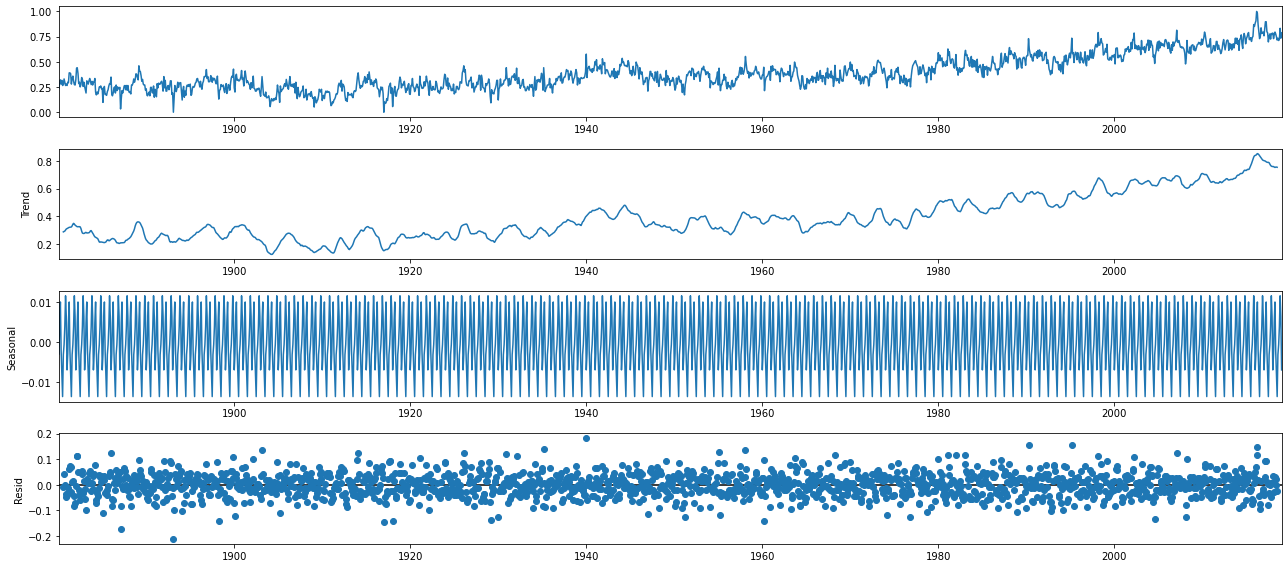

In [25]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_plot, model='additive')
fig = decomposition.plot()
plt.show()

# Fit the model 

In [65]:
# We can set the uncertainty interval to 95% (interval_width=0.95), the Prophet default is 80%
model = Prophet()
model.fit(dff)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -22.5031


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3589.94     0.0122882       154.772           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3600.95     0.0235368       289.801           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       3601.99   0.000640859       298.411   2.801e-06       0.001      289  LS failed, Hessian reset 
     299        3605.8    0.00124015       102.793   1.626e-05       0.001      438  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     348       3606.46   0.000178383       89.6438   1.005e-06       0.001      538  LS failed, Hessian reset 
     399       3606.91   0.000863655       64.2711           1           1      617   
    Iter      log prob        ||dx||  

[Here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) is a reference to the acceptable freq parameter aliases

In [66]:
# como quiero los proximos 50 años mi periodo es de 50 con una frecuencia de años
future = model.make_future_dataframe(periods=1, freq='Y')
future.tail()

,ds
1664,2018-09-30
1665,2018-10-31
1666,2018-11-30
1667,2018-12-31
1668,2019-12-31


Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting, which are:

- ds: the datestamp of the forecasted value
- yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- yhat_lower: the lower bound of our forecasts
- yhat_upper: the upper bound of our forecasts


A variation in values from the output presented above is to be expected as Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts. MCMC is a stochastic process, so values will be slightly different each time.


In [67]:
forecast = model.predict(future)
forecast = round(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 2)
forecast.head()

,ds,yhat,yhat_lower,yhat_upper
0,1880-01-31,0.27,0.18,0.36
1,1880-02-29,0.29,0.21,0.38
2,1880-03-31,0.30,0.21,0.38
3,1880-04-30,0.28,0.19,0.36
4,1880-05-31,0.28,0.19,0.37


In [68]:
max_date = dff['ds'].max() 

forecast_filtered =  forecast[forecast['ds'] < max_date]   


In [69]:
dff.head()

,date,y,ds
0,1880-01-31,0.237209,1880-01-31
1,1880-02-29,0.288372,1880-02-29
2,1880-03-31,0.320930,1880-03-31
3,1880-04-30,0.279070,1880-04-30
4,1880-05-31,0.316279,1880-05-31


In [70]:
forecast["real"] = dff["y"]

In [71]:
forecast.head()

,ds,yhat,yhat_lower,yhat_upper,real
0,1880-01-31,0.27,0.18,0.36,0.237209
1,1880-02-29,0.29,0.21,0.38,0.288372
2,1880-03-31,0.30,0.21,0.38,0.320930
3,1880-04-30,0.28,0.19,0.36,0.279070
4,1880-05-31,0.28,0.19,0.37,0.316279


In [72]:
px.line(forecast, x = "ds", y = ["yhat", "real"], title = "Comparison of predicted vs real values for January")


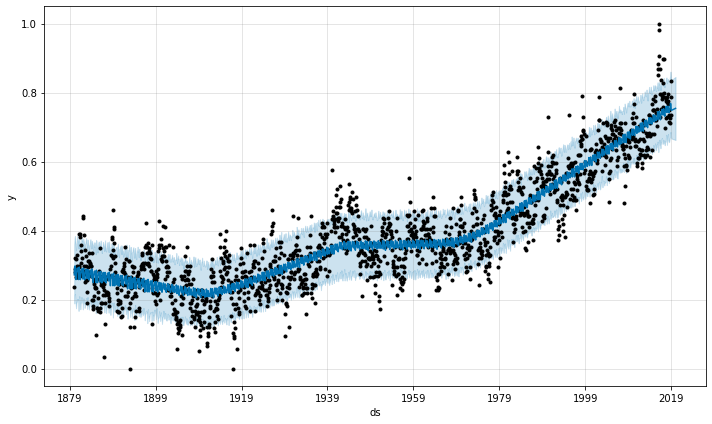

In [40]:
# uncertainty is the error of our predictions
fig1 = model.plot(forecast, uncertainty = True)